In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.layers import TimeDistributed, Reshape, InputLayer
from tensorflow.keras.optimizers import Adam

In [17]:
# Set parameters
IMG_SIZE = 128
BATCH_SIZE = 32
DATASET_PATH = 'Batch'  # Path with 'normal' and 'sick' subfolders

# 1. Load and preprocess images
def load_data():
    X, y = [], []
    classes = ['normal', 'abnormal']
    for label, class_name in enumerate(classes):
        folder_path = os.path.join(DATASET_PATH, class_name)
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='grayscale')
                img_array = img_to_array(img) / 255.0
                X.append(img_array)
                y.append(label)
    return np.array(X), np.array(y)

X, y = load_data()
y_cat = to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

In [18]:
# Helper to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    report = classification_report(y_true, y_pred_classes, target_names=['normal', 'sick'], output_dict=True)
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=['normal', 'sick']))
    print(f"\nNumerical Results for {model_name}:")
    print(f"Accuracy : {report['accuracy']}")
    print(f"Precision: {report['weighted avg']['precision']}")
    print(f"Recall   : {report['weighted avg']['recall']}")
    print(f"F1 Score : {report['weighted avg']['f1-score']}")
    return report

In [19]:
# 2. CNN Model
def build_cnn():
    model = Sequential([
        InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
cnn.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)
cnn_metrics = evaluate_model(cnn, X_test, y_test, 'CNN')

Epoch 1/10
45/45 [==============================] - 20s 414ms/step - loss: 0.7110 - accuracy: 0.5819 - val_loss: 0.6562 - val_accuracy: 0.6687
Epoch 2/10
45/45 [==============================] - 18s 397ms/step - loss: 0.5983 - accuracy: 0.6875 - val_loss: 0.5365 - val_accuracy: 0.7188
Epoch 3/10
45/45 [==============================] - 18s 406ms/step - loss: 0.4288 - accuracy: 0.7931 - val_loss: 0.4267 - val_accuracy: 0.8125
Epoch 4/10
45/45 [==============================] - 18s 397ms/step - loss: 0.3321 - accuracy: 0.8715 - val_loss: 0.4123 - val_accuracy: 0.8125
Epoch 5/10
45/45 [==============================] - 18s 397ms/step - loss: 0.2467 - accuracy: 0.8972 - val_loss: 0.3725 - val_accuracy: 0.8438
Epoch 6/10
45/45 [==============================] - 18s 404ms/step - loss: 0.2044 - accuracy: 0.9285 - val_loss: 0.3668 - val_accuracy: 0.8313
Epoch 7/10
45/45 [==============================] - 18s 394ms/step - loss: 0.1444 - accuracy: 0.9472 - val_loss: 0.4611 - val_accuracy: 0.8562

In [20]:
# 3. RNN Model (convert image rows to sequences)
def build_rnn():
    model = Sequential([
        InputLayer(input_shape=(IMG_SIZE, IMG_SIZE)),
        SimpleRNN(64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn = build_rnn()
rnn.fit(X_train.reshape(-1, IMG_SIZE, IMG_SIZE), y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)
rnn_metrics = evaluate_model(rnn, X_test.reshape(-1, IMG_SIZE, IMG_SIZE), y_test, 'RNN')

Epoch 1/10
45/45 [==============================] - 2s 20ms/step - loss: 0.6874 - accuracy: 0.5576 - val_loss: 0.6878 - val_accuracy: 0.5437
Epoch 2/10
45/45 [==============================] - 1s 16ms/step - loss: 0.6627 - accuracy: 0.5986 - val_loss: 0.6700 - val_accuracy: 0.5500
Epoch 3/10
45/45 [==============================] - 1s 16ms/step - loss: 0.6298 - accuracy: 0.6549 - val_loss: 0.6616 - val_accuracy: 0.6062
Epoch 4/10
45/45 [==============================] - 1s 15ms/step - loss: 0.6060 - accuracy: 0.6597 - val_loss: 0.6485 - val_accuracy: 0.6250
Epoch 5/10
45/45 [==============================] - 1s 18ms/step - loss: 0.5792 - accuracy: 0.6944 - val_loss: 0.6286 - val_accuracy: 0.7000
Epoch 6/10
45/45 [==============================] - 1s 17ms/step - loss: 0.5662 - accuracy: 0.7153 - val_loss: 0.6307 - val_accuracy: 0.6313
Epoch 7/10
45/45 [==============================] - 1s 17ms/step - loss: 0.5500 - accuracy: 0.7285 - val_loss: 0.6698 - val_accuracy: 0.6687
Epoch 8/10
45

In [21]:
# 4. Bidirectional RNN

def build_birnn():
    model = Sequential([
        InputLayer(input_shape=(IMG_SIZE, IMG_SIZE)),
        Bidirectional(SimpleRNN(64)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

birnn = build_birnn()
birnn.fit(X_train.reshape(-1, IMG_SIZE, IMG_SIZE), y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)
birnn_metrics = evaluate_model(birnn, X_test.reshape(-1, IMG_SIZE, IMG_SIZE), y_test, 'Bidirectional RNN')

Epoch 1/10
45/45 [==============================] - 3s 26ms/step - loss: 0.6916 - accuracy: 0.5507 - val_loss: 0.6076 - val_accuracy: 0.7188
Epoch 2/10
45/45 [==============================] - 1s 21ms/step - loss: 0.6356 - accuracy: 0.6319 - val_loss: 0.6034 - val_accuracy: 0.6250
Epoch 3/10
45/45 [==============================] - 1s 21ms/step - loss: 0.6051 - accuracy: 0.6736 - val_loss: 0.5859 - val_accuracy: 0.7312
Epoch 4/10
45/45 [==============================] - 1s 20ms/step - loss: 0.5934 - accuracy: 0.6958 - val_loss: 0.5352 - val_accuracy: 0.7437
Epoch 5/10
45/45 [==============================] - 1s 23ms/step - loss: 0.5378 - accuracy: 0.7368 - val_loss: 0.5186 - val_accuracy: 0.7625
Epoch 6/10
45/45 [==============================] - 1s 20ms/step - loss: 0.4812 - accuracy: 0.7778 - val_loss: 0.5998 - val_accuracy: 0.6562
Epoch 7/10
45/45 [==============================] - 1s 21ms/step - loss: 0.4962 - accuracy: 0.7701 - val_loss: 0.5170 - val_accuracy: 0.7750
Epoch 8/10
45

In [22]:
# 5. LSTM Model
def build_lstm():
    model = Sequential([
        InputLayer(input_shape=(IMG_SIZE, IMG_SIZE)),
        LSTM(64),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm = build_lstm()
lstm.fit(X_train.reshape(-1, IMG_SIZE, IMG_SIZE), y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1, verbose=1)
lstm_metrics = evaluate_model(lstm, X_test.reshape(-1, IMG_SIZE, IMG_SIZE), y_test, 'LSTM')

Epoch 1/10
45/45 [==============================] - 4s 51ms/step - loss: 0.7045 - accuracy: 0.5326 - val_loss: 0.6882 - val_accuracy: 0.5562
Epoch 2/10
45/45 [==============================] - 2s 40ms/step - loss: 0.6759 - accuracy: 0.5660 - val_loss: 0.6662 - val_accuracy: 0.6438
Epoch 3/10
45/45 [==============================] - 2s 45ms/step - loss: 0.6596 - accuracy: 0.6146 - val_loss: 0.6799 - val_accuracy: 0.5312
Epoch 4/10
45/45 [==============================] - 2s 49ms/step - loss: 0.6631 - accuracy: 0.5785 - val_loss: 0.6587 - val_accuracy: 0.6062
Epoch 5/10
45/45 [==============================] - 2s 43ms/step - loss: 0.6373 - accuracy: 0.6236 - val_loss: 0.6664 - val_accuracy: 0.6438
Epoch 6/10
45/45 [==============================] - 2s 41ms/step - loss: 0.6223 - accuracy: 0.6514 - val_loss: 0.6326 - val_accuracy: 0.6250
Epoch 7/10
45/45 [==============================] - 2s 41ms/step - loss: 0.6145 - accuracy: 0.6542 - val_loss: 0.6323 - val_accuracy: 0.6438
Epoch 8/10
45

In [23]:
def plot_results(*metrics_dicts):
    names = ['CNN', 'RNN', 'Bi-RNN', 'LSTM']
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # Extract values for each metric
    accuracies = [m['accuracy'] for m in metrics_dicts]
    precisions = [m['weighted avg']['precision'] for m in metrics_dicts]
    recalls = [m['weighted avg']['recall'] for m in metrics_dicts]
    f1_scores = [m['weighted avg']['f1-score'] for m in metrics_dicts]
    
    all_metrics = [accuracies, precisions, recalls, f1_scores]

    # Plotting
    plt.figure(figsize=(16, 6))
    for i, metric in enumerate(all_metrics):
        plt.subplot(1, 4, i+1)
        plt.bar(names, metric, color='skyblue')
        plt.title(metrics_labels[i])
        plt.ylim(0, 1)
        for j, val in enumerate(metric):
            plt.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
        plt.xlabel('Model')
        plt.ylabel(metrics_labels[i])
    plt.tight_layout()
    plt.show()


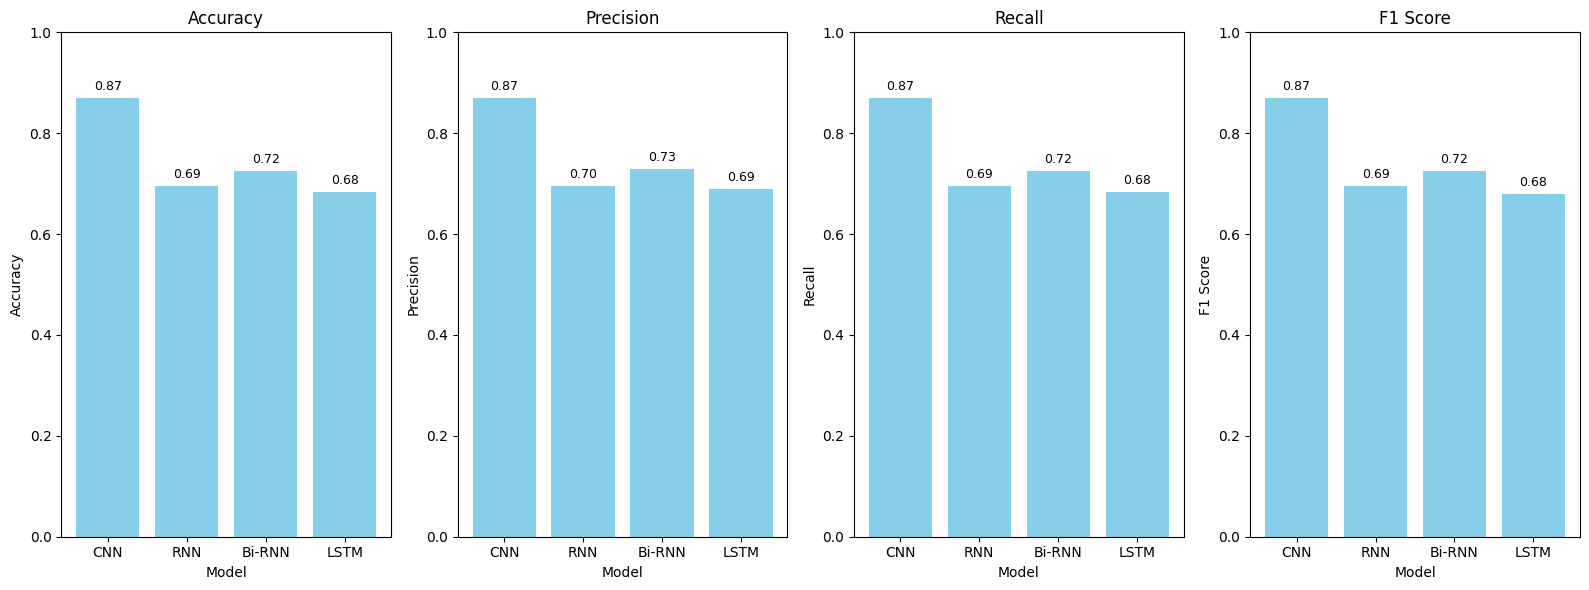

In [24]:
plot_results(cnn_metrics, rnn_metrics, birnn_metrics, lstm_metrics)